# **2023 NFL Big Data Bowl EDA**
### Sol Ben-Ishay

## **Data Extraction/Cleaning**

### **Import libraries**

In [1]:
# Import libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nfl_data_py as nfl
from utils import animate_play

### **Read in the data**

In [2]:
# Read in the internal BDB competition data
games_df = pd.read_csv("../Data/games.csv")
plays_df = pd.read_csv("../Data/plays.csv")
players_df = pd.read_csv("../Data/players.csv")
scouting_df = pd.read_csv("../Data/pffScoutingData.csv")
tracking_df_list = ["../Data/tracking/week1.csv", "../Data/tracking/week2.csv", "../Data/tracking/week3.csv", "../Data/tracking/week4.csv",
"../Data/tracking/week5.csv", "../Data/tracking/week6.csv", "../Data/tracking/week7.csv", "../Data/tracking/week8.csv"]
tracking_df = pd.concat(map(pd.read_csv, tracking_df_list))

### **Create+clean the main data**

In [3]:
# Get the play-level data
coi = ['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'playId',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'foulName1', 'foulNFLId1',
       'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType']
play_level_df = games_df.merge(plays_df, on='gameId', how='left')[coi]

# Replace n/a yardlineSide
play_level_df = play_level_df.fillna(value={'yardlineSide': 'MIDDLE'})

# Drop one play with null absolute yard line number
play_level_df = play_level_df[~((play_level_df.gameId == 2021091904) & (play_level_df.playId == 3676))]

# play_level_df.head(5)

In [4]:
# Get the player-level data
coi = ['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       'pff_role', 'pff_positionLinedUp', 'pff_hit', 'pff_hurry',
       'pff_sack', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed', 'pff_nflIdBlockedPlayer',
       'pff_blockType', 'pff_backFieldBlock']
player_level_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(scouting_df, on=['gameId','playId'], how='left')
                .merge(players_df, on='nflId', how='left'))[coi]

# Get whether a defender got a pressure on the play
player_level_df['pff_pressure'] = player_level_df[['pff_hit','pff_hurry','pff_sack']].sum(axis=1)
                
# player_level_df.head(5)

In [5]:
# Get the frame-level data
coi = ['gameId', 'playId', 'frameId', 'event', 'time', 'nflId', 'displayName', 'team', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']
frame_level_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(tracking_df, on=['gameId','playId'], how='left')
                .merge(players_df, on='nflId', how='left'))[coi]

# Convert dt_time column to time
frame_level_df['time'] = pd.to_datetime(frame_level_df['time'])

# Replace n/a values for ball rows   
frame_level_df = frame_level_df.fillna(value={"nflId":0,"displayName":"ball"})

# frame_level_df.head(5)

#### **Check for NAs**

In [6]:
# Check for NA data
ok_na_cols = ["penaltyYards", "foulName1", "foulNFLId1", "foulName2", "foulNFLId2",
            "foulName3", "foulNFLId3", "offenseFormation", "personnelO", "defendersInBox",
            "personnelD", "dropBackType"]
if sum(play_level_df.loc[:,~play_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(play_level_df.loc[:,~play_level_df.columns.isin(ok_na_cols)].isna().sum().loc[lambda x: x > 0])

In [7]:
# Check for NA data
ok_na_cols = ["pff_hit", "pff_hurry", "pff_sack", "pff_beatenByDefender",
            "pff_hitAllowed", "pff_hurryAllowed", "pff_sackAllowed",
            "pff_nflIdBlockedPlayer", "pff_blockType", "pff_backFieldBlock"]
if sum(player_level_df.loc[:,~player_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(player_level_df.isna().sum().loc[lambda x: x > 0])

In [8]:
# Check for NA data
ok_na_cols = ['o','dir']
if sum(frame_level_df.loc[:,~frame_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(frame_level_df.isna().sum().loc[lambda x: x > 0])

## **Exploratory Data Analysis**

### **Play-level data**

In [9]:
play_level_df.head(3)

,gameId,season,week,homeTeamAbbr,visitorTeamAbbr,playId,playDescription,quarter,down,yardsToGo,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,2021,1,TB,DAL,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,2021,1,TB,DAL,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,...,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone


In [10]:
print(f"Play-level df columns:\n{list(play_level_df.columns)}\n")
print("Play-level df info:")
print(play_level_df.info(verbose=False))

Play-level df columns:
['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'penaltyYards', 'prePenaltyPlayResult', 'playResult', 'foulName1', 'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3', 'absoluteYardlineNumber', 'offenseFormation', 'personnelO', 'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction', 'pff_passCoverage', 'pff_passCoverageType']

Play-level df info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8556 entries, 0 to 8556
Columns: 36 entries, gameId to pff_passCoverageType
dtypes: float64(6), int64(13), object(17)
memory usage: 2.4+ MB
None


#### **Univariate analysis**

In [11]:
# Descriptive statistics
play_level_df[['yardsToGo','yardlineNumber','penaltyYards','prePenaltyPlayResult',
            'playResult','absoluteYardlineNumber','defendersInBox','pff_playAction']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
yardsToGo,8556.0,8.724170,3.913277,0.0,6.0,10.0,10.00,39.0
yardlineNumber,8556.0,29.905446,12.508020,1.0,22.0,30.0,40.00,50.0
penaltyYards,756.0,3.534392,11.620723,-18.0,-5.0,4.0,11.25,50.0
prePenaltyPlayResult,8556.0,6.500117,10.195786,-34.0,0.0,4.0,10.00,91.0
playResult,8556.0,6.563114,10.611579,-34.0,0.0,5.0,11.00,91.0
absoluteYardlineNumber,8556.0,59.247195,23.658446,11.0,40.0,59.0,79.00,109.0
defendersInBox,8550.0,6.022339,1.005467,1.0,5.0,6.0,7.00,11.0
pff_playAction,8556.0,0.238079,0.425932,0.0,0.0,0.0,0.00,1.0


In [12]:
# Number of offensive/defensive plays per team
display(play_level_df[['possessionTeam']].value_counts().reset_index(name='num_plays_on_off').head())
display(play_level_df[['defensiveTeam']].value_counts().reset_index(name='num_plays_on_def').head())

,possessionTeam,num_plays_on_off
0,KC,339
1,DET,328
2,MIA,309
3,TB,309
4,NYG,299


,defensiveTeam,num_plays_on_def
0,CIN,331
1,TB,324
2,LA,318
3,TEN,316
4,WAS,308


In [13]:
# passResult counts
play_level_df[['passResult']].value_counts().reset_index(name='passResult_counts').head()

,passResult,passResult_counts
0,C,4619
1,I,2755
2,S,543
3,R,449
4,IN,190


In [14]:
# Most common offensive/defensive personnel groups
display(play_level_df[['personnelO']].value_counts().reset_index(name='personnelO_counts').head())
display(play_level_df[['personnelD']].value_counts().reset_index(name='personnelD_counts').head())

,personnelO,personnelO_counts
0,"1 RB, 1 TE, 3 WR",5750
1,"1 RB, 2 TE, 2 WR",1501
2,"2 RB, 1 TE, 2 WR",437
3,"1 RB, 3 TE, 1 WR",227
4,"1 RB, 0 TE, 4 WR",184


,personnelD,personnelD_counts
0,"4 DL, 2 LB, 5 DB",2420
1,"2 DL, 4 LB, 5 DB",1541
2,"3 DL, 3 LB, 5 DB",1147
3,"2 DL, 3 LB, 6 DB",799
4,"4 DL, 3 LB, 4 DB",682


#### **Multivariate analysis**

In [15]:
# Descriptive statistics grouped by passResult
# Numeric variables with no evident relationship with passResult: 'penaltyYards','prePenaltyPlayResult','playResult','pff_playAction'
play_level_df[['passResult','penaltyYards','prePenaltyPlayResult','playResult','pff_playAction']].groupby("passResult").describe().transpose()

passResult                            C            I          IN           R  \
penaltyYards         count   275.000000   351.000000   23.000000   64.000000   
                     mean     -0.887273     7.165242    9.086957    0.109375   
                     std       9.169830    12.737393   11.147413    9.560363   
                     min     -15.000000   -18.000000  -15.000000  -15.000000   
                     25%     -10.000000     0.000000    5.000000  -10.000000   
                     50%       0.000000     5.000000    7.000000    0.000000   
                     75%       5.000000    15.000000   14.500000    5.000000   
                     max      26.000000    50.000000   48.000000   15.000000   
prePenaltyPlayResult count  4619.000000  2755.000000  190.000000  449.000000   
                     mean     12.114960     0.000000    0.000000    7.719376   
                     std      10.350233     0.000000    0.000000    6.121654   
                     min      -8.000000     0.000000    0.000000    1.000000   
                     25%       6.000000     0.000000    0.000000    4.000000   
                     50%       9.000000     0.000000    0.000000    6.000000   
                     75%      15.000000     0.000000    0.000000   10.000000   
                     max      91.000000     0.000000    0.000000   39.000000   
playResult           count  4619.000000  2755.000000  190.000000  449.000000   
                     mean     11.680234     0.912886    0.000000    7.164811   
                     std      10.819443     5.131145    0.000000    7.663079   
                     min     -27.000000   -18.000000    0.000000  -15.000000   
                     25%       5.000000     0.000000    0.000000    3.000000   
                     50%       9.000000     0.000000    0.000000    6.000000   
                     75%      15.000000     0.000000    0.000000   11.000000   
                     max      91.000000    50.000000    0.000000   42.000000   
pff_playAction       count  4619.000000  2755.000000  190.000000  449.000000   
                     mean      0.241394     0.225408    0.215789    0.287305   
                     std       0.427975     0.417927    0.412456    0.453010   
                     min       0.000000     0.000000    0.000000    0.000000   
                     25%       0.000000     0.000000    0.000000    0.000000   
                     50%       0.000000     0.000000    0.000000    0.000000   
                     75%       0.000000     0.000000    0.000000    1.000000   
                     max       1.000000     1.000000    1.000000    1.000000   

passResult                           S  
penaltyYards         count   43.000000  
                     mean     4.302326  
                     std      7.156532  
                     min    -15.000000  
                     25%      0.000000  
                     50%      5.000000  
                     75%      8.000000  
                     max     15.000000  
prePenaltyPlayResult count  543.000000  
                     mean    -7.016575  
                     std      3.817529  
                     min    -34.000000  
                     25%     -9.000000  
                     50%     -7.000000  
                     75%     -5.000000  
                     max      0.000000  
playResult           count  543.000000  
                     mean    -6.499079  
                     std      5.090283  
                     min    -34.000000  
                     25%     -9.000000  
                     50%     -7.000000  
                     75%     -4.000000  
                     max     15.000000  
pff_playAction       count  543.000000  
                     mean     0.241252  
                     std      0.428238  
                     min      0.000000  
                     25%      0.000000  
                     50%      0.000000  
                     75%      0.000000  
                     max      1.000000

<AxesSubplot: >

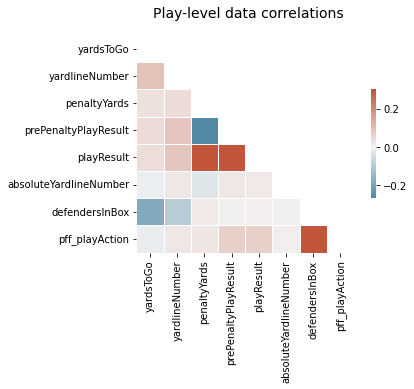

In [16]:
# Correlation matrix of numeric data
coi = ['yardsToGo','yardlineNumber','penaltyYards','prePenaltyPlayResult',
            'playResult','absoluteYardlineNumber','defendersInBox','pff_playAction']
corr = play_level_df[coi].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f = plt.figure().suptitle(t="Play-level data correlations",fontsize=14)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### **Player-level data**

In [17]:
player_level_df.head(3)

,gameId,playId,nflId,displayName,officialPosition,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,pff_pressure
0,2021090900,97,25511,Tom Brady,QB,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2021090900,97,35481,Rob Gronkowski,TE,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2021090900,97,35634,Antonio Brown,WR,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [18]:
print(f"Player-level df columns:\n{list(player_level_df.columns)}\n")
print("Player-level df info:")
print(player_level_df.info(verbose=False))

Player-level df columns:
['gameId', 'playId', 'nflId', 'displayName', 'officialPosition', 'pff_role', 'pff_positionLinedUp', 'pff_hit', 'pff_hurry', 'pff_sack', 'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed', 'pff_nflIdBlockedPlayer', 'pff_blockType', 'pff_backFieldBlock', 'pff_pressure']

Player-level df info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 188254 entries, 0 to 188253
Columns: 18 entries, gameId to pff_pressure
dtypes: float64(10), int64(3), object(5)
memory usage: 27.3+ MB
None


#### **Univariate analysis**

In [19]:
# Descriptive statistics for numeric data for OL/DL
print("OL Descriptive Statistics:")
display(player_level_df.query("officialPosition in ['C','G','T','TE']")[['pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed','pff_backFieldBlock']].describe().transpose())
print("DL Descriptive Statistics:")
display(player_level_df.query("officialPosition in ['NT','DT','DE','OLB']")[['pff_hit', 'pff_hurry', 'pff_sack', 'pff_pressure']].describe().transpose())


OL Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
pff_beatenByDefender,45484.0,0.040784,0.197791,0.0,0.0,0.0,0.0,1.0
pff_hitAllowed,45484.0,0.011059,0.104579,0.0,0.0,0.0,0.0,1.0
pff_hurryAllowed,45484.0,0.043246,0.203413,0.0,0.0,0.0,0.0,1.0
pff_sackAllowed,45484.0,0.007255,0.084869,0.0,0.0,0.0,0.0,1.0
pff_backFieldBlock,45437.0,0.001761,0.041924,0.0,0.0,0.0,0.0,1.0


DL Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
pff_hit,39398.0,0.017996,0.132938,0.0,0.0,0.0,0.0,1.0
pff_hurry,39398.0,0.064090,0.244915,0.0,0.0,0.0,0.0,1.0
pff_sack,39398.0,0.013046,0.113475,0.0,0.0,0.0,0.0,1.0
pff_pressure,39398.0,0.095132,0.293401,0.0,0.0,0.0,0.0,1.0


In [20]:
# Most common positions for OL/DL
display(player_level_df.query("officialPosition in ['C','G','T','TE']")['officialPosition'].value_counts().reset_index().head())
display(player_level_df.query("officialPosition in ['NT','DT','DE','OLB']")['officialPosition'].value_counts().reset_index().head())

,index,officialPosition
0,T,17926
1,G,16546
2,TE,10496
3,C,8414


,index,officialPosition
0,DE,13646
1,OLB,12972
2,DT,9828
3,NT,2952


In [21]:
# Most common roles for OL/DL
display(player_level_df.query("officialPosition in ['C','G','T','TE']")['pff_role'].value_counts().reset_index().head())
display(player_level_df.query("officialPosition in ['NT','DT','DE','OLB']")['pff_role'].value_counts().reset_index().head())

,index,pff_role
0,Pass Block,44309
1,Pass Route,9069
2,Pass Rush,4


,index,pff_role
0,Pass Rush,33777
1,Coverage,5621


In [22]:
# Most common positions lined up for OL/DL
display(player_level_df.query("officialPosition in ['C','G','T','TE']")['pff_positionLinedUp'].value_counts().reset_index().head())
display(player_level_df.query("officialPosition in ['NT','DT','DE','OLB']")['pff_positionLinedUp'].value_counts().reset_index().head())

,index,pff_positionLinedUp
0,LT,8557
1,LG,8557
2,RG,8557
3,C,8557
4,RT,8555


,index,pff_positionLinedUp
0,DRT,4810
1,LEO,4657
2,ROLB,4449
3,DLT,4371
4,REO,4286


In [23]:
# Most common block types for OL
display(player_level_df.query("officialPosition in ['C','G','T','TE']")['pff_blockType'].value_counts().reset_index().head())

,index,pff_blockType
0,PP,24659
1,PA,6291
2,PT,5898
3,SW,3021
4,CL,2573


#### **Multivariate analysis**

In [24]:
# OL statistic means grouped by player/position
print("OL Statistics Means:")
coi = ['displayName', 'officialPosition', 'pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']
display(player_level_df.query("officialPosition in ['C','G','T']")[coi]
.groupby(['displayName','officialPosition']).mean().reset_index().sort_values(by="pff_beatenByDefender",ascending=True).head())

# DL statistic means grouped by player/position
print("DL Statistics Means:")
coi = ['displayName', 'officialPosition', 'pff_hit', 'pff_hurry', 'pff_sack', 'pff_pressure']
display(player_level_df.query("officialPosition in ['NT','DT','DE']")[coi]
.groupby(['displayName','officialPosition']).mean().reset_index().sort_values(by="pff_pressure",ascending=False).head())

OL Statistics Means:


,displayName,officialPosition,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed
45,Calvin Anderson,T,0.0,0.0,0.100000,0.000000
248,Trenton Brown,T,0.0,0.0,0.000000,0.000000
229,Saahdiq Charles,T,0.0,0.0,0.051282,0.076923
62,Coleman Shelton,G,0.0,0.0,0.000000,0.000000
112,J.C. Hassenauer,C,0.0,0.0,0.000000,0.000000


DL Statistics Means:


,displayName,officialPosition,pff_hit,pff_hurry,pff_sack,pff_pressure
71,Daniel Wise,DE,0.000000,0.500000,0.000000,0.500000
200,Margus Hunt,DT,0.000000,0.400000,0.000000,0.400000
66,Da'Shawn Hand,DE,0.000000,0.250000,0.000000,0.250000
181,Khalil Davis,DT,0.000000,0.250000,0.000000,0.250000
221,Myles Garrett,DE,0.042654,0.137441,0.056872,0.236967


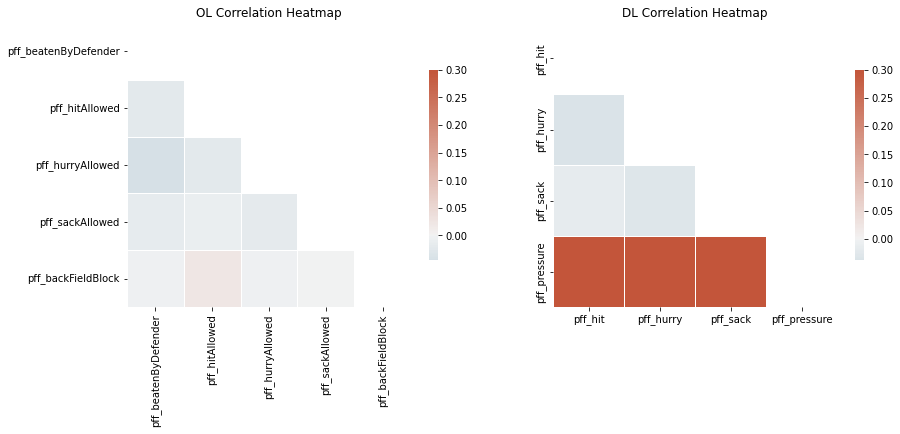

In [25]:
# Correlation matrix of numeric data for OL
coi = ['pff_beatenByDefender', 'pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed','pff_backFieldBlock']
corr = player_level_df.query("officialPosition in ['C','G','T']")[coi].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, (ax1,ax2) = plt.subplots(1,2,figsize=[14,7])
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)
ax1.title.set_text("OL Correlation Heatmap")

# Correlation matrix of numeric data for DL
coi = ['pff_hit', 'pff_hurry', 'pff_sack', 'pff_pressure']
corr = player_level_df.query("officialPosition in ['NT','DT','DE']")[coi].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)
ax2.title.set_text("DL Correlation Heatmap")

### **Frame-level data**

In [26]:
frame_level_df.head(3)

,gameId,playId,frameId,event,time,nflId,displayName,team,playDirection,x,y,s,a,dis,o,dir
0,2021090900,97,1,None,2021-09-10 00:26:31.100,25511.0,Tom Brady,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99
1,2021090900,97,2,None,2021-09-10 00:26:31.200,25511.0,Tom Brady,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87
2,2021090900,97,3,None,2021-09-10 00:26:31.300,25511.0,Tom Brady,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55


In [27]:
print(f"Frame-level df columns:\n{list(frame_level_df.columns)}\n")
print("Frame-level df info:")
print(frame_level_df.info(verbose=False))

Frame-level df columns:
['gameId', 'playId', 'frameId', 'event', 'time', 'nflId', 'displayName', 'team', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']

Frame-level df info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8314178 entries, 0 to 8314177
Columns: 16 entries, gameId to dir
dtypes: datetime64[ns](1), float64(8), int64(3), object(4)
memory usage: 1.1+ GB
None


#### **Univariate analysis**

In [28]:
# Descriptive statistics for numeric data for OL/DL
coi = ["gameId","playId","nflId"]
ol_on_play_df = player_level_df.query("officialPosition in ['C','G','T']")[coi]
dl_on_play_df = player_level_df.query("officialPosition in ['NT','DT','DE']")[coi]

print("OL Descriptive Statistics:")
coi = ['gameId','playId','nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']
display(ol_on_play_df.merge(frame_level_df[coi], how='left', on=['gameId','playId','nflId'])
.drop(columns=["gameId","playId","nflId"]).describe().transpose())

print("DL Descriptive Statistics:")
display(dl_on_play_df.merge(frame_level_df[coi], how='left', on=['gameId','playId','nflId'])
.drop(columns=["gameId","playId","nflId"]).describe().transpose())

OL Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
x,1811820.0,59.332468,24.233475,2.51,38.59,59.13,79.60,118.30
y,1811820.0,26.760509,4.072436,2.70,23.83,26.77,29.68,54.58
s,1811820.0,1.577493,1.112184,0.00,0.64,1.56,2.37,7.30
a,1811820.0,1.182836,0.811497,0.00,0.58,1.11,1.69,10.97
dis,1811820.0,0.163043,0.114372,0.00,0.07,0.16,0.24,2.97
o,1811820.0,181.649615,99.294030,0.00,89.92,187.67,269.64,360.00
dir,1811820.0,178.164243,100.247662,0.00,89.06,173.78,268.77,360.00


DL Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
x,1113622.0,59.329357,24.293620,2.55,38.90,59.08,79.49,119.81
y,1113622.0,26.758447,4.737058,-2.38,23.58,26.76,29.94,55.03
s,1113622.0,2.157033,1.518917,0.00,0.90,2.12,3.18,8.92
a,1113622.0,1.554475,1.037074,0.00,0.76,1.47,2.23,10.70
dis,1113622.0,0.222674,0.155814,0.00,0.09,0.22,0.33,2.13
o,1113622.0,178.048411,98.903173,0.00,89.37,170.16,269.17,360.00
dir,1113622.0,179.165472,99.480297,0.00,90.06,173.08,269.99,360.00


#### **Multivariate analysis**

In [29]:
coi = ["gameId","playId","nflId"]
ol_on_play_df = player_level_df.query("officialPosition in ['C','G','T']")[coi]
dl_on_play_df = player_level_df.query("officialPosition in ['NT','DT','DE']")[coi]

# OL statistic means grouped by player/position
print("OL Descriptive Statistics:")
coi = ['gameId','playId','nflId', 'displayName', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']
display(ol_on_play_df.merge(frame_level_df[coi], how='left', on=['gameId','playId','nflId'])
.drop(columns=["gameId","playId"]).groupby(["nflId","displayName"]).mean(numeric_only=True).reset_index()
.sort_values(by="s",ascending=False))

# DL statistic means grouped by player/position
print("DL Descriptive Statistics:")
display(dl_on_play_df.merge(frame_level_df[coi], how='left', on=['gameId','playId','nflId'])
.drop(columns=["gameId","playId"]).groupby(["nflId","displayName"]).mean(numeric_only=True).reset_index()
.sort_values(by="s",ascending=False))

OL Descriptive Statistics:


,nflId,displayName,x,y,s,a,dis,o,dir
262,53543,Drew Dalman,97.077805,27.063089,2.555122,1.322195,0.263252,134.896423,235.758455
159,46323,Korey Cunningham,48.239190,26.714579,2.411682,1.375981,0.249502,131.913333,223.885296
220,52516,Saahdiq Charles,51.578975,26.401184,2.181037,1.477791,0.225705,196.124716,172.670958
80,42587,Trenton Brown,48.546632,33.359158,2.034000,1.311579,0.211579,215.725263,100.960316
191,47985,Isaiah Prince,77.754660,26.637136,1.989320,1.300874,0.205631,146.892767,164.280971
...,...,...,...,...,...,...,...,...,...
193,48085,Fred Johnson,88.322385,25.023303,1.234037,1.124128,0.125963,83.083670,218.223211
160,46376,Coleman Shelton,20.798375,24.849000,1.197500,1.077250,0.123125,91.336000,253.505625
271,53861,Robert Jones,85.760208,26.526597,1.162500,0.852639,0.120833,111.274722,219.926181
269,53635,Landon Young,99.666400,24.580400,0.664000,0.605600,0.067600,124.386800,166.082800


DL Descriptive Statistics:


,nflId,displayName,x,y,s,a,dis,o,dir
134,45063,Pat O'Connor,67.578967,27.264859,2.888052,1.532864,0.301854,173.722066,162.592300
286,53935,Darius Hodge,70.919160,25.045649,2.856718,1.871260,0.297672,131.990687,116.271107
39,41249,Dee Ford,59.231490,26.788814,2.826942,1.966395,0.294396,187.233942,184.134150
122,44915,Trey Hendrickson,58.216592,25.987456,2.733729,1.805593,0.283801,165.104705,169.574333
218,52456,Darrell Taylor,60.979843,26.662955,2.731478,1.977586,0.283101,161.055176,168.192126
...,...,...,...,...,...,...,...,...,...
92,43392,Sheldon Day,57.614774,24.818442,1.540101,1.266683,0.158794,165.643618,135.404874
276,53618,Marlon Tuipulotu,65.063885,25.858417,1.498741,1.216960,0.153975,135.183309,140.090090
249,52829,Breiden Fehoko,47.573624,27.719161,1.443523,1.545067,0.142047,151.520403,154.482215
204,48462,Kevin Strong,67.795793,27.751389,1.389295,1.260763,0.143209,163.404932,171.961076


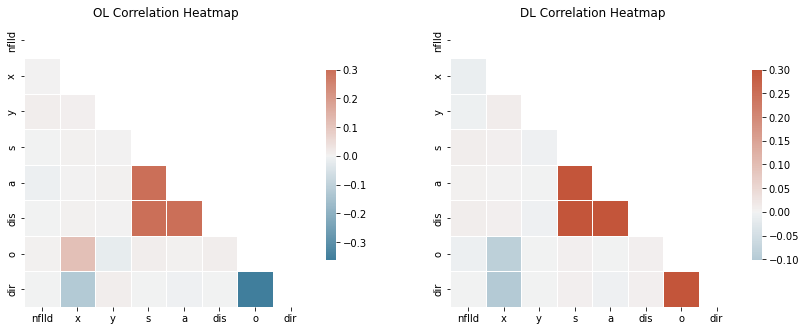

In [30]:
# Correlation matrix of numeric data for OL
coi = ['gameId','playId','nflId', 'displayName', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']
corr = (ol_on_play_df.merge(frame_level_df[coi], how='left', on=['gameId','playId','nflId'])
.drop(columns=["gameId","playId"]).corr(numeric_only=True))
mask = np.triu(np.ones_like(corr, dtype=bool))
f, (ax1,ax2) = plt.subplots(1,2,figsize=[14,7])
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)
ax1.title.set_text("OL Correlation Heatmap")

# Correlation matrix of numeric data for DL
corr = (dl_on_play_df.merge(frame_level_df[coi], how='left', on=['gameId','playId','nflId'])
.drop(columns=["gameId","playId"]).corr(numeric_only=True))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)
ax2.title.set_text("DL Correlation Heatmap")

## **Data Wrangling/Transformation/Feature Engineering**

### **Secondary data**

#### **Time of the snap and "action" for each play**

*Get the time of the snap and action event for each play for further use*

An action event is defined as the earliest of the following:  
  - A throw  
  - A non-throw, but play-ending event (QB sack, strip sack)
  - Any play where the QB doesn't scramble  
  - NOT YET: 3.5 seconds post-snap

A hard time cap is useful for reducing noise introduced by “broken” plays. Plays without a targeted receiver are not used for training, but are included for predictions so that players can be quantified on all pass plays.

In [31]:
# 1. Get the time of all the key events for each play (all individual snap/action events)
potential_snap_events = ['ball_snap', 'autoevent_ballsnap']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
conds = f"(event in {potential_snap_events}) or (event in {potential_action_events})"
coi = ['gameId', 'playId', 'event', 'frameId', 'time']
play_event_times_df = frame_level_df.query(conds)[coi].drop_duplicates()

# 2. Get the time of the snap and action event for each play
# Note: Not distinguishing snap/action times based on if they're from auto/manual events
# Utilizing the times of the earliest snap and earliest action event to calculate the snap to action time.
play_event_times_df.loc[play_event_times_df['event'].isin(potential_snap_events),'event'] = "ballsnap"
play_event_times_df.loc[play_event_times_df['event'].isin(potential_action_events),'event'] = "action"
play_event_times_df = play_event_times_df.groupby(['gameId','playId','event']).min().reset_index().sort_values(by=['time'])

# 3. Get the frame of the snap
coi = ['gameId','playId','frameId']
frame_of_snap_df = play_event_times_df.query("event == 'ballsnap'")[coi]

# 4. Get the frame of the action
coi = ['gameId','playId','frameId']
frame_of_action_df = play_event_times_df.query("event == 'action'")[coi]

#### **Time from the snap to "action" for each play**

*Get the time from snap to an action event for each play for further analyses*

An action event is defined as the earliest of the following:  
  - A throw  
  - A non-throw, but play-ending event (QB sack, strip sack)
  - Any play where the QB doesn't scramble  
  - NOT YET: 3.5 seconds post-snap

A hard time cap is useful for reducing noise introduced by “broken” plays. Plays without a targeted receiver are not used for training, but are included for predictions so that players can be quantified on all pass plays.

In [32]:
# 1. Drop rows where the tracking data is missing either a snap or action event
bad_rows = (play_event_times_df[['gameId','playId','event']]
            .groupby(['gameId','playId']).count().reset_index()
            .query('event != 2').drop(columns=['event']))
outer = play_event_times_df.merge(bad_rows, on=['gameId','playId'], how='outer', indicator=True)
play_event_times_df = outer[outer._merge == 'left_only'].drop(columns=['_merge'])

# 2. Get the snap to action event time for each play
coi = ['gameId', 'playId', 'time']
snap_to_action_df = play_event_times_df[coi].groupby(['gameId', 'playId']).agg(lambda x: np.max(x) - np.min(x)).reset_index().rename(columns={'time':'snap_to_action_time'})
snap_to_action_df['snap_to_action_time'] = snap_to_action_df['snap_to_action_time'].apply(lambda x: x.total_seconds())
snap_to_action_df = snap_to_action_df.sort_values(by=['snap_to_action_time']).reset_index(drop=True)
snap_to_action_df.head()

,gameId,playId,snap_to_action_time
0,2021100307,2997,0.5
1,2021100304,293,0.5
2,2021103105,2596,0.7
3,2021101707,2181,0.7
4,2021092610,2033,0.8


#### **Players for each play by position**

In [33]:
coi = ["gameId","playId","nflId"]
#1. Get the DL for each play
pass_rushers_on_play_df = player_level_df.query("officialPosition in ['NT','DT','DE']")[coi]
#2. Get the OL for each play
ol_on_play_df = player_level_df.query("officialPosition in ['C','G','T','TE','FB']")[coi]
#3. Get the QB for each play
qb_on_play_df = player_level_df.query("pff_role == 'Pass' and officialPosition == 'QB'")[coi]

#### **Tracking data for each player by position**

In [34]:
coi = ['gameId', 'playId', 'nflId', 'frameId', 'x', 'y', 's', 'o', 'dir', 'playDirection']
# 1. Get the tracking data of the DL at every frame
pass_rushers_pos_df = pass_rushers_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]
# 2. Get the tracking data of the OL/LOS blockers for each frame
ol_pos_df = ol_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]
# 3. Get the tracking data of the QB for each frame
qb_pos_df = qb_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]

### **Feature Engineering**

#### **Pre-Snap Features**

##### **Pass Rushers' Alignment**

*Get the pre-snap alignment (edge, head-up, or in gap) for each of the pass rushers for each play*

In [35]:
# 1. Get the y position of the pass rushers 2 frames before the snap
coi = ['gameId', 'playId', 'nflId', 'frameId', 'y']
pass_rushers_pos_presnap_df = (pass_rushers_pos_df[coi]
                            .merge(frame_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
                            .query("frameId == (frameId_snap-2)")
                            .drop(columns=["frameId","frameId_snap"]))

# 2. Get the y position of the OL/LOS blockers 2 frames before the snap
ol_pos_presnap_df = (ol_pos_df[coi]
                    .merge(frame_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
                    .query("frameId == (frameId_snap-2)")
                    .drop(columns=["frameId","frameId_snap"]))

#3. Group by game, play, and d-lineman and get the position of all the offensive linemen on the play in a list
dl_alignment_df = pass_rushers_pos_presnap_df.merge(ol_pos_presnap_df, on=['gameId','playId'], how='left', suffixes=['_dl','_ol']).drop(columns=["nflId_ol"])
dl_alignment_df = dl_alignment_df.groupby(["gameId","playId","nflId_dl","y_dl"])['y_ol'].apply(list).reset_index()
dl_alignment_df = dl_alignment_df.sort_values(by=["gameId","playId","y_dl"])
dl_alignment_df['y_ol'] = dl_alignment_df['y_ol'].apply(sorted)

#4. Set the conditions for each alignment (edge, head-up, or in gap)
threshold_for_edge = .5
threshold_for_head_up = .25

edge_cond = (((dl_alignment_df.y_dl + threshold_for_edge) < dl_alignment_df.y_ol.apply(lambda x: min(x))) |
((dl_alignment_df.y_dl - threshold_for_edge) > dl_alignment_df.y_ol.apply(lambda x: max(x))))

head_up_lambda = (lambda x: abs(x['y_ol'][np.abs(np.asarray(x['y_ol']) - x['y_dl']).argmin()] - x['y_dl']))
head_up_cond = ((~edge_cond) &
                (dl_alignment_df.apply(head_up_lambda, axis=1) < threshold_for_head_up))

gap_cond = ((~edge_cond) & (~head_up_cond))

#5. Get the alignment
dl_alignment_df.loc[edge_cond, 'dl_alignment'] = 'edge'
dl_alignment_df.loc[head_up_cond, 'dl_alignment'] = 'head_up'
dl_alignment_df.loc[gap_cond, 'dl_alignment'] = 'gap'

dl_alignment_df = dl_alignment_df.drop(columns=['y_dl','y_ol']).rename(columns={"nflId_dl":"nflId"})

dl_alignment_df.head()

,gameId,playId,nflId,dl_alignment
0,2021090900,97,41263,edge
2,2021090900,97,44955,gap
3,2021090900,97,53504,head_up
1,2021090900,97,42403,edge
5,2021090900,137,35454,edge


#### **Intra-Play Features**

##### **Pass Rushers' Num of Blockers**

In [36]:
# 1. Get the number of blockers per pass rusher on each play
ol = ['C','G','T','TE','FB','RB']
conds = f"pff_role == 'Pass Block' and officialPosition in {ol}"

# 2. Get the blocking assignments of the offensive linemen
coi = ['gameId', 'playId', 'nflId', 'pff_nflIdBlockedPlayer', 'pff_beatenByDefender']
ol_blocks_df = player_level_df.query(conds)[coi]
ol_blocks_df = ol_blocks_df.rename(columns={"nflId":"nflIdBlocker","pff_nflIdBlockedPlayer":"nflIdDefender","pff_beatenByDefender":"beatBlocker"})
ol_blocks_df.head()

# 3. Get the num of blockers per defender
dl_num_blockers_df = ol_blocks_df[['gameId','playId','nflIdDefender','nflIdBlocker']].groupby(['gameId','playId','nflIdDefender']).count().reset_index().rename(columns={'nflIdDefender':'nflId','nflIdBlocker':'numBlockers'})
dl_num_blockers_df.loc[dl_num_blockers_df['numBlockers'] == 1, 'multBlockers'] = "N"
dl_num_blockers_df.loc[dl_num_blockers_df['numBlockers'] > 1, 'multBlockers'] = "Y"
dl_num_blockers_df.head()

,gameId,playId,nflId,numBlockers,multBlockers
0,2021090900,97,42403.0,1,N
1,2021090900,97,44955.0,2,Y
2,2021090900,97,53441.0,2,Y
3,2021090900,137,35441.0,2,Y
4,2021090900,137,35454.0,1,N


##### **Pass Rushers' Metrics at Key Points in Time**

*Get the tracking metrics + depth behind the LOS + dist of each of the pass rushers from the QB for specific points in time after the snap for each play*

In [37]:
def get_dl_metrics_at_time(time_after_snap):
    """
    Returns a dataframe with the metrics of every DL at the selected point in time after the snap

    Args:
        time: Either a positive float representing the time in seconds (to the tenths place) after the snap or "release" for at release time
    Returns:
        This is a description of what is returned.
    Raises:
        KeyError: Raises an exception.
    """

    if isinstance(time_after_snap, float) or isinstance(time_after_snap, int):
        col_str = str(time_after_snap)
        col_names = {"x":f"x_at_{col_str}","y":f"y_at_{col_str}","s":f"speed_at_{col_str}","o":f"o_at_{col_str}","dir":f"dir_at_{col_str}"}
        num_frames_after_snap = time_after_snap * 10

         # 1. Get the metrics of the QB at the selected time
        qb_pos_at_key_df = (qb_pos_df
                        .merge(frame_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
                        .query(f"frameId == (frameId_snap+{num_frames_after_snap})")
                        .drop(columns=["nflId","frameId","frameId_snap","s","o","dir","playDirection"])
                        .rename(columns=col_names))

        # 2. Get the metrics of the pass rushers at the selected time
        pass_rushers_pos_at_key_df = (pass_rushers_pos_df
                                .merge(frame_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
                                .query(f"frameId == (frameId_snap+{num_frames_after_snap})")
                                .drop(columns=["frameId","frameId_snap"])
                                .rename(columns=col_names))

    elif time_after_snap == "release":
        col_str = "rel"
        col_names = {"x":f"x_at_{col_str}","y":f"y_at_{col_str}","s":f"speed_at_{col_str}","o":f"o_at_{col_str}","dir":f"dir_at_{col_str}"}

        # 1. Get the position of the QB at release
        qb_pos_at_key_df = (frame_of_action_df
                            .merge(qb_pos_df, on=['gameId','playId','frameId'], how='left')
                            .drop(columns=["nflId","frameId","s","o","dir","playDirection"])
                            .rename(columns=col_names))

        # 2. Get the positions of the pass rushers at release
        pass_rushers_pos_at_key_df = (frame_of_action_df
                                    .merge(pass_rushers_pos_df, on=['gameId','playId','frameId'], how='left')
                                    .drop(columns=['frameId'])
                                    .rename(columns=col_names))

    else:
        raise ValueError("Invalid input to 'time_after_snap!'")

    # 4. Get the depth of the pass rushers at the selected time
    pass_rushers_depth_at_key_df = pass_rushers_pos_at_key_df.merge(play_level_df[['gameId','playId','absoluteYardlineNumber']], on=['gameId','playId'], how='left')
    pass_rushers_depth_at_key_df.loc[pass_rushers_depth_at_key_df.playDirection == 'right', f'depth_at_{col_str}'] = pass_rushers_depth_at_key_df['absoluteYardlineNumber'] - pass_rushers_depth_at_key_df[f'x_at_{col_str}']
    pass_rushers_depth_at_key_df.loc[pass_rushers_depth_at_key_df.playDirection == 'left', f'depth_at_{col_str}'] = pass_rushers_depth_at_key_df[f'x_at_{col_str}'] - pass_rushers_depth_at_key_df['absoluteYardlineNumber']
    pass_rushers_depth_at_key_df = pass_rushers_depth_at_key_df[['gameId','playId','nflId', f'x_at_{col_str}', f'y_at_{col_str}', f'speed_at_{col_str}',f'o_at_{col_str}',f'dir_at_{col_str}',f'depth_at_{col_str}']]

    # 5. Get the distances of the pass rushers from the QB at the selected time
    rusher_dist_at_key_df = pass_rushers_pos_at_key_df.merge(qb_pos_at_key_df, how='left', on=['gameId','playId'], suffixes=['_pr','_qb'])
    rusher_dist_at_key_df['x2-x1'] = (rusher_dist_at_key_df[f'x_at_{col_str}_qb'] - rusher_dist_at_key_df[f'x_at_{col_str}_pr'])**2
    rusher_dist_at_key_df['y2-y1'] = (rusher_dist_at_key_df[f'y_at_{col_str}_qb'] - rusher_dist_at_key_df[f'y_at_{col_str}_pr'])**2
    rusher_dist_at_key_df[f'distance_at_{col_str}'] = np.sqrt(rusher_dist_at_key_df['x2-x1'] + rusher_dist_at_key_df['y2-y1'])
    rusher_dist_at_key_df = rusher_dist_at_key_df[['gameId','playId','nflId',f'distance_at_{col_str}']]

    # 6. Get all the metrics of the pass rushers at the selected time
    pass_rushers_at_key_df = pass_rushers_depth_at_key_df.merge(rusher_dist_at_key_df, on=['gameId','playId','nflId'], how='outer')

    return pass_rushers_at_key_df

In [38]:
# Get metrics at 1.5 seconds after the snap
pass_rushers_at_key_df = get_dl_metrics_at_time(1.5)
# Get metrics at 2 seconds after the snap
pass_rushers_at_key2_df = get_dl_metrics_at_time(2)
# Get metrics at release (only "distance from qb" for now)
rusher_dist_at_rel_df = get_dl_metrics_at_time("release")[['gameId', 'playId', 'nflId', 'distance_at_rel']]

##### **Pass Rushers' Time to Depth**

In [39]:
# 1. Set the depth and the condition for when a player is at depth depending on the play direction
depth = 3
right_play_dir_cond = f"(playDirection == 'right') and (x <= absoluteYardlineNumber - {depth})"
left_play_dir_cond = f"(playDirection == 'left') and (x >= absoluteYardlineNumber + {depth})"

# 2. Get all the frames/times at depth for each pass rusher
time_at_depth_df = (play_level_df[['gameId','playId','absoluteYardlineNumber']]
                .merge(frame_level_df, on = ['gameId','playId'], how = 'left')
                .merge(player_level_df[['gameId','playId','nflId', 'officialPosition']], on= ['gameId','playId','nflId'], how='left')
                .query(f"officialPosition in ['NT','DT','DE'] and ({right_play_dir_cond} or {left_play_dir_cond})"))

# 3. Get the minimum frame/time at depth for each pass rusher
coi = ['gameId','playId','nflId', 'displayName', 'time']
min_time_at_depth_df = time_at_depth_df[coi].groupby(['gameId', 'playId', 'nflId', 'displayName']).min().reset_index().rename(columns={'time':'depth_time'})

# 4. Get the time of snap for each play (to calculate the time after snap at depth)
coi = ['gameId','playId','time']
time_of_snap_df = play_event_times_df.query("event == 'ballsnap'")[coi].rename(columns={'time':'snap_time'})

# 5. Get the time after snap to depth for each pass rusher (if they got to depth)
time_to_depth_df = min_time_at_depth_df.merge(time_of_snap_df, on=['gameId','playId'], how='left')
time_to_depth_df["time_to_depth"] = time_to_depth_df['depth_time'] - time_to_depth_df['snap_time']
time_to_depth_df["time_to_depth"] = time_to_depth_df["time_to_depth"].dt.total_seconds()
time_to_depth_df = time_to_depth_df[['gameId', 'playId', 'nflId', 'time_to_depth']].sort_values(by='time_to_depth')

# 6. Drop weird time_to_depth value less than zero (means the player was 3 yds behind the LOS before the snap, bad tracking data?)
time_to_depth_df = time_to_depth_df.query("~(gameId == 2021091204 and playId == 2699 and nflId == 45011)")

time_to_depth_df.head()

,gameId,playId,nflId,time_to_depth
507,2021091201,500,47975.0,0.5
18784,2021102407,3881,47889.0,0.7
17523,2021102400,3971,53540.0,0.8
19780,2021103101,3439,35470.0,0.8
19558,2021103100,1456,47799.0,0.9


## **Offensive Line Analysis**

### **Individual**

#### **Quarterbacks**

In [40]:
# Get the plays for QBs who played more than 30 snaps
coi = ['gameId','playId','nflId','displayName','officialPosition']
high_snap_qbs = player_level_df.query("officialPosition == 'QB'").nflId.value_counts().loc[lambda c: c > 30].index.tolist()
qb_df = player_level_df[coi].query(f"nflId in {high_snap_qbs}")

qb_df.head()

,gameId,playId,nflId,displayName,officialPosition
0,2021090900,97,25511,Tom Brady,QB
31,2021090900,137,43424,Dak Prescott,QB
51,2021090900,187,43424,Dak Prescott,QB
75,2021090900,282,43424,Dak Prescott,QB
96,2021090900,349,43424,Dak Prescott,QB


In [41]:
# Average snap to action times by QBs
qb_avg_rel_time_df = qb_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')
qb_avg_rel_time_df = qb_avg_rel_time_df[["displayName","snap_to_action_time"]].groupby("displayName").mean().sort_values(by=['snap_to_action_time'],ascending=[True]).reset_index()
qb_avg_rel_time_df.head()

,displayName,snap_to_action_time
0,Ben Roethlisberger,2.661765
1,Mike White,2.697368
2,Tom Brady,2.787908
3,Cooper Rush,2.793478
4,Mac Jones,2.820641


In [42]:
# Pass result counts by QB
qb_pass_results = qb_df.merge(play_level_df[['gameId','playId','passResult']], on = ['gameId', 'playId'], how='left')
qb_pass_results.head()

qb_pass_result_counts = (qb_pass_results[["displayName", "passResult"]]
                    .groupby(["displayName","passResult"])
                    .value_counts().reset_index(name="count").sort_values(by=["passResult", "count"], ascending=[True, False]))
qb_pass_result_counts.head()

,displayName,passResult,count
74,Jared Goff,C,189
173,Tom Brady,C,179
124,Matt Ryan,C,176
119,Mac Jones,C,170
138,Patrick Mahomes,C,167


### **Team**

In [43]:
# Get the play-level OL relevant data only for plays with QBs who played more than 30 snaps (to account for outlying events such as when a typical starter is injured)
# high_snap_qbs = player_level_df.query("officialPosition == 'QB'").nflId.value_counts().loc[lambda c: c > 30].index.tolist()
coi = ['gameId', 'playId', 'possessionTeam', 'passResult', 'prePenaltyPlayResult']
ol_df = play_level_df[coi]
ol_df = ol_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

ol_df.head()

,gameId,playId,possessionTeam,passResult,prePenaltyPlayResult,snap_to_action_time
0,2021090900,97,TB,I,0,3.2
1,2021090900,137,DAL,C,28,2.6
2,2021090900,187,DAL,C,5,2.0
3,2021090900,282,DAL,I,0,3.2
4,2021090900,349,DAL,I,0,2.6


#### **Descriptive Statistics**

In [44]:
# Two-way descriptive statistics
pass_res_des_stats = ol_df[["passResult", "prePenaltyPlayResult", "snap_to_action_time"]].groupby("passResult")[["snap_to_action_time", "prePenaltyPlayResult"]].describe()
pass_res_des_stats

snap_to_action_time                                                \
                         count      mean       std  min  25%  50%  75%   max   
passResult                                                                     
C                       4604.0  2.800500  1.020795  0.5  2.2  2.6  3.2  17.1   
I                       2750.0  3.187855  1.297617  0.5  2.4  2.9  3.6  19.2   
IN                       189.0  3.315873  1.096785  0.7  2.6  3.1  3.6   7.3   
R                        447.0  4.306711  1.228747  1.4  3.4  4.2  4.9   8.7   
S                        542.0  4.421033  1.212763  1.0  3.6  4.3  5.0   9.6   

           prePenaltyPlayResult                                              \
                          count       mean        std   min  25%  50%   75%   
passResult                                                                    
C                        4619.0  12.114960  10.350233  -8.0  6.0  9.0  15.0   
I                        2755.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
IN                        190.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
R                         449.0   7.719376   6.121654   1.0  4.0  6.0  10.0   
S                         543.0  -7.016575   3.817529 -34.0 -9.0 -7.0  -5.0   

                  
             max  
passResult        
C           91.0  
I            0.0  
IN           0.0  
R           39.0  
S            0.0

#### **Exploratory Plots**

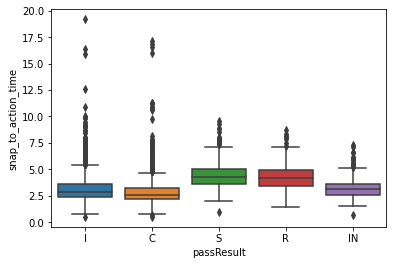

In [45]:
# Boxplot of the snap to action time vs pass result
box = sns.boxplot(data=ol_df, x="passResult", y="snap_to_action_time")
plt.show()

## **Defensive Line Analysis**

### **Individual**

In [46]:
## Get the player-level DL relevant data
# Note: For players who pass rushed more than 35 snaps and for plays their role was "Pass Rush" (to account for noise)
# Note: potentially consider OLB in DL
high_snap_pass_rushers = player_level_df.query("officialPosition in ['NT','DT','DE'] and pff_role == 'Pass Rush'").nflId.value_counts().loc[lambda c: c > 35].index.tolist()
coi = ['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       'pff_role', 'pff_positionLinedUp', 'pff_hit', 'pff_hurry', 'pff_sack', 'pff_pressure']
dl_df = (player_level_df[coi].query(f"nflId in {high_snap_pass_rushers} and pff_role == 'Pass Rush'")
        .merge(play_level_df[['gameId','playId','passResult']], how='left', on=['gameId','playId'])
        .merge(dl_alignment_df, how='left', on=['gameId','playId','nflId'])
        .merge(dl_num_blockers_df, how='left', on=['gameId','playId','nflId'])
        .merge(time_to_depth_df, how='left', on=['gameId','playId','nflId'])
        .merge(pass_rushers_at_key_df, how='left', on=['gameId','playId','nflId'])
        .merge(pass_rushers_at_key2_df, how='left', on=['gameId','playId','nflId'])
        .merge(rusher_dist_at_rel_df, how='left', on=['gameId','playId','nflId'])
        .merge(snap_to_action_df, how='left', on=['gameId','playId']))

## Clean up NAs
# A missing snap_to_action_time/distance at rel occurs when a certain play is missing either a snap or action event
dl_df = dl_df.dropna(subset=['snap_to_action_time','distance_at_rel'], how='any')
# numBlockers and multBlockers is N/A when a player is unblocked
dl_df = dl_df.fillna(value={'numBlockers':0,'multBlockers':'U'})

## Filter plays
# Only look at plays that were either C, I, S, or IN (no scrambles, laterals, etc)
dl_df = dl_df.query("passResult in ['C','I','S','IN','R']")
#  Only look at plays that have a snap to action time within the 95th percentile
dl_df = dl_df[dl_df.snap_to_action_time < dl_df.snap_to_action_time.quantile(.95)]

dl_df.head()

,gameId,playId,nflId,displayName,officialPosition,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,...,distance_at_1.5,x_at_2,y_at_2,speed_at_2,o_at_2,dir_at_2,depth_at_2,distance_at_2,distance_at_rel,snap_to_action_time
0,2021090900,97,42403,Randy Gregory,DE,Pass Rush,ROLB,0.0,1.0,0.0,...,6.073986,36.25,27.65,4.13,135.21,225.82,6.75,4.312957,3.805391,3.2
1,2021090900,97,44955,Carlos Watkins,DE,Pass Rush,DRT,0.0,0.0,0.0,...,5.720813,39.79,26.28,1.41,6.93,316.73,3.21,6.086156,10.437672,3.2
2,2021090900,97,53504,Osa Odighizuwa,DT,Pass Rush,RE,0.0,1.0,0.0,...,6.234645,39.95,23.96,4.04,301.80,219.79,3.05,5.741054,2.496498,3.2
3,2021090900,137,35441,Ndamukong Suh,DE,Pass Rush,DRT,0.0,0.0,0.0,...,4.446268,111.97,23.30,2.01,108.91,80.32,3.97,4.191718,3.635505,2.6
4,2021090900,137,35454,Jason Pierre-Paul,DE,Pass Rush,ROLB,0.0,0.0,0.0,...,5.298726,111.18,22.79,2.39,57.38,32.79,3.18,5.019691,5.145600,2.6


In [47]:
# Check for NAs
# A missing time_to_depth occurs when the rusher did not make it to 3 yards
# Missing metrics at 2 seconds indicate plays that did not last 2 seconds (maybe should filter out?)
if sum(dl_df.isna().sum().values) != 0:
    print(dl_df.isna().sum().loc[lambda x: x > 0])

dl_alignment       60
time_to_depth    3489
x_at_2            108
y_at_2            108
speed_at_2        108
o_at_2            108
dir_at_2          108
depth_at_2        108
distance_at_2     108
dtype: int64


#### **Descriptive Statistics/Exploratory Plots**

In [48]:
# Descriptive statistics
coi = ["snap_to_action_time", "pff_hit", "pff_hurry", "pff_sack", "pff_pressure", "distance_at_rel",
 "distance_at_1.5", "depth_at_1.5", "speed_at_1.5", "distance_at_2", "depth_at_2", "speed_at_2", "time_to_depth", "numBlockers"]
dl_df[coi].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
snap_to_action_time,23633.0,2.925299,0.862356,0.500000,2.300000,2.800000,3.400000,5.400000
pff_hit,23633.0,0.019253,0.137415,0.000000,0.000000,0.000000,0.000000,1.000000
pff_hurry,23633.0,0.063598,0.244040,0.000000,0.000000,0.000000,0.000000,1.000000
pff_sack,23633.0,0.011552,0.106858,0.000000,0.000000,0.000000,0.000000,1.000000
pff_pressure,23633.0,0.094402,0.292393,0.000000,0.000000,0.000000,0.000000,1.000000
distance_at_rel,23633.0,5.005908,3.128369,0.040000,3.287324,4.365375,5.682051,39.241072
distance_at_1.5,23633.0,5.374922,0.963498,1.127298,4.756848,5.313718,5.923462,11.608794
depth_at_1.5,23633.0,2.411829,1.281167,-1.610000,1.560000,2.360000,3.250000,7.860000
speed_at_1.5,23633.0,3.081584,1.105890,0.000000,2.330000,3.050000,3.830000,6.640000
distance_at_2,23525.0,5.263221,1.466868,0.454533,4.282347,5.095498,6.066366,13.930790


In [49]:
# Descriptive statistics grouped by pressureOnPlay (either pff sack, hit, or hurry)
coi = ["pff_pressure", "distance_at_1.5", "depth_at_1.5", "speed_at_1.5", "distance_at_2", "depth_at_2", "speed_at_2", "time_to_depth"]
dl_df[coi].groupby('pff_pressure').describe().transpose()

pff_pressure                    0.0          1.0
distance_at_1.5 count  21402.000000  2231.000000
                mean       5.401189     5.122940
                std        0.957830     0.981385
                min        1.736001     1.127298
                25%        4.782489     4.486167
                50%        5.334899     5.122577
                75%        5.941368     5.701754
                max       11.608794    10.000290
depth_at_1.5    count  21402.000000  2231.000000
                mean       2.361748     2.892255
                std        1.275188     1.238477
                min       -1.610000    -0.760000
                25%        1.500000     2.020000
                50%        2.320000     2.810000
                75%        3.180000     3.760000
                max        7.860000     6.940000
speed_at_1.5    count  21402.000000  2231.000000
                mean       3.029629     3.579982
                std        1.098272     1.053687
                min        0.000000     0.140000
                25%        2.290000     2.875000
                50%        3.000000     3.550000
                75%        3.770000     4.250000
                max        6.480000     6.640000
distance_at_2   count  21296.000000  2229.000000
                mean       5.348020     4.453047
                std        1.456851     1.306594
                min        0.927631     0.454533
                25%        4.364737     3.577625
                50%        5.162407     4.405916
                75%        6.133256     5.294308
                max       13.930790     9.637282
depth_at_2      count  21296.000000  2229.000000
                mean       3.564441     4.512140
                std        1.766766     1.584721
                min       -2.020000    -0.870000
                25%        2.430000     3.430000
                50%        3.490000     4.480000
                75%        4.690000     5.600000
                max        9.790000     8.990000
speed_at_2      count  21296.000000  2229.000000
                mean       2.653925     3.543751
                std        1.112099     1.066616
                min        0.010000     0.150000
                25%        1.860000     2.860000
                50%        2.590000     3.520000
                75%        3.400000     4.260000
                max        7.280000     7.460000
time_to_depth   count  17924.000000  2220.000000
                mean       1.815376     1.679324
                std        0.535437     0.465018
                min        0.500000     0.800000
                25%        1.400000     1.400000
                50%        1.700000     1.600000
                75%        2.100000     1.900000
                max        5.800000     4.900000

<AxesSubplot: xlabel='pff_pressure', ylabel='speed_at_1.5'>

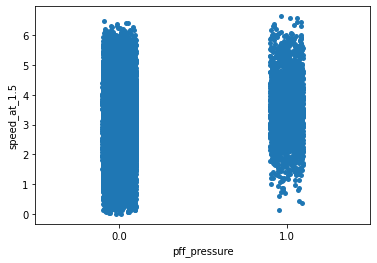

In [50]:
# Depth at 2 vs pressureOnPlay
sns.stripplot(dl_df, x="pff_pressure", y="speed_at_1.5")

<AxesSubplot: xlabel='pff_pressure', ylabel='speed_at_2'>

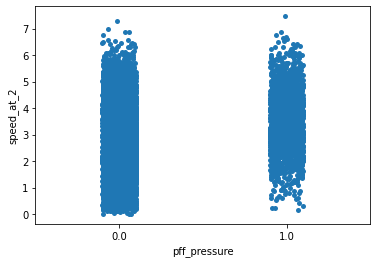

In [51]:
# Distance at 2 vs pressureOnPlay
sns.stripplot(dl_df, x="pff_pressure", y="speed_at_2")

#### **Player-level Frequencies**

In [52]:
# Two-way frequency table (multiple blockers and pff pressure)
pd.crosstab(index=dl_df['multBlockers'], columns=dl_df['pff_pressure'], normalize='index')

pff_pressure,0.0,1.0
multBlockers,,
N,0.887146,0.112854
U,0.823581,0.176419
Y,0.946358,0.053642


In [53]:
# Frequencies of multBlockers on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'multBlockers']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['multBlockers','%'],ascending=[False,False])
.head(5))

,nflId,displayName,officialPosition,multBlockers,%
394,46618,Taylor Stallworth,DT,Y,0.675000
236,43638,Justin Zimmer,DT,Y,0.670588
63,39960,Star Lotulelei,DT,Y,0.663366
19,35522,Corey Peters,DT,Y,0.657143
54,38619,Akiem Hicks,DT,Y,0.642105


In [54]:
# Frequencies of pressureOnPlay on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'pff_pressure']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['pff_pressure','%'],ascending=[False,False])
.head(5))

,nflId,displayName,officialPosition,pff_pressure,%
311,47889,Maxx Crosby,DE,1.0,0.213592
179,44813,Myles Garrett,DE,1.0,0.210256
11,35470,Jerry Hughes,DE,1.0,0.198413
206,44915,Trey Hendrickson,DE,1.0,0.196970
99,42403,Randy Gregory,DE,1.0,0.187050


In [55]:
# Frequencies of multBlockers/pressureOnPlay on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'multBlockers','pff_pressure']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['pff_pressure','%'],ascending=[False,False])
.head(5))


,nflId,displayName,officialPosition,multBlockers,pff_pressure,%
26,35470,Jerry Hughes,DE,N,1.0,0.174603
437,44813,Myles Garrett,DE,N,1.0,0.164103
509,44915,Trey Hendrickson,DE,N,1.0,0.156566
778,47889,Maxx Crosby,DE,N,1.0,0.150485
885,52462,A.J. Epenesa,DE,N,1.0,0.148148


#### **Player-level Average Statistics**

In [56]:
# Player-level average statistics (on plays they got pressures to see if their is a visually evident relationship with any features)
coi = ['nflId', 'displayName', 'officialPosition', 'pff_hit', 'pff_hurry',
    'pff_sack', 'pff_pressure', 'distance_at_rel', 'distance_at_1.5',
    'depth_at_1.5', 'speed_at_1.5', 'distance_at_2', 'depth_at_2', 'speed_at_2',
    'time_to_depth', 'numBlockers']

indy_dl_avg_df = dl_df[coi].groupby(['nflId', 'displayName', 'officialPosition']).mean().reset_index()

indy_dl_avg_df.sort_values(by=['distance_at_2','speed_at_2'], ascending=[True, True]).head(10)

,nflId,displayName,officialPosition,pff_hit,pff_hurry,pff_sack,pff_pressure,distance_at_rel,distance_at_1.5,depth_at_1.5,speed_at_1.5,distance_at_2,depth_at_2,speed_at_2,time_to_depth,numBlockers
76,43358,Yannick Ngakoue,DE,0.031579,0.094737,0.021053,0.147368,3.974127,5.015479,4.115053,4.187263,4.238851,5.857672,3.524868,1.342623,1.010526
89,44813,Myles Garrett,DE,0.046154,0.123077,0.041026,0.210256,4.346014,5.300203,3.841282,4.073744,4.549193,5.388763,3.465206,1.414439,1.123077
79,43378,Javon Hargrave,DT,0.036364,0.090909,0.030303,0.157576,4.084931,4.670862,2.359030,2.704606,4.577651,3.565273,2.511273,1.749242,1.569697
143,47787,Clelin Ferrell,DE,0.020408,0.081633,0.000000,0.102041,4.371946,5.249168,3.629388,3.914694,4.592136,5.262857,3.479796,1.458333,1.020408
142,47786,Quinnen Williams,NT,0.020134,0.087248,0.026846,0.134228,4.706534,4.663267,2.191611,2.827919,4.667353,3.278993,2.491946,1.813559,1.416107
130,46199,Josh Sweat,DE,0.024845,0.080745,0.031056,0.136646,3.982746,5.454301,3.563540,4.003354,4.696400,5.235093,3.448012,1.480645,1.024845
49,42403,Randy Gregory,DE,0.050360,0.100719,0.035971,0.187050,4.340388,5.394498,3.147698,3.931079,4.699955,4.709712,3.472158,1.600741,1.007194
199,53053,Bryce Huff,DE,0.037594,0.060150,0.030075,0.127820,4.611611,5.356279,3.423985,3.911955,4.739721,5.006541,3.296466,1.496154,1.022556
32,41239,Aaron Donald,DT,0.029046,0.091286,0.012448,0.132780,4.722844,5.030540,2.917884,3.329876,4.749505,4.275500,2.950125,1.605116,1.535270
93,44838,Takkarist McKinley,DE,0.026316,0.052632,0.017544,0.096491,4.511288,5.661302,3.370263,4.177982,4.774042,4.973509,3.753772,1.532727,1.096491


#### **Player-level Cumulative Statistics**

In [57]:
indy_dl_cum_df = (dl_df[['nflId','displayName','officialPosition','pff_hit','pff_hurry','pff_sack','pff_pressure']].groupby(['nflId','displayName','officialPosition']).sum().sort_values(by=['pff_pressure'],ascending=[False]))
indy_dl_cum_df

,,,pff_hit,pff_hurry,pff_sack,pff_pressure
nflId,displayName,officialPosition,,,,
47889,Maxx Crosby,DE,12.0,27.0,5.0,44.0
44813,Myles Garrett,DE,9.0,24.0,8.0,41.0
44915,Trey Hendrickson,DE,6.0,25.0,8.0,39.0
41239,Aaron Donald,DT,7.0,22.0,3.0,32.0
44829,Jonathan Allen,DT,8.0,16.0,6.0,30.0
...,...,...,...,...,...,...
44905,Montravius Adams,DE,0.0,0.0,0.0,0.0
52582,Larrell Murchison,DT,0.0,0.0,0.0,0.0
46438,Tyler Lancaster,NT,0.0,0.0,0.0,0.0


## **ML Models**

In [58]:
# Code snippet to train/test a classification model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

def run_experiment(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

### **Predict whether a player will get a pressure on a play**

In [59]:
# Get the training/test data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Model Data w N/As dropped for model
model_df = dl_df.dropna()
model_df.head()

# Features
feature_cols = [
       # 'officialPosition', 'pff_role', 'pff_positionLinedUp',
       'speed_at_1.5', 'depth_at_1.5', 'distance_at_1.5',
       'speed_at_2', 'depth_at_2', 'distance_at_2',
       'time_to_depth', 'numBlockers']
features = model_df[feature_cols]

# Target
target = model_df['pff_pressure']

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle=True)

# Balance the sample of training data with/without a pressure
under_sampler = RandomUnderSampler(random_state=77)
x_train, y_train = under_sampler.fit_resample(x_train, y_train)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

x_train.head()

Training target statistics: Counter({0.0: 1775, 1.0: 1775})
Testing target statistics: Counter({0.0: 3569, 1.0: 438})


,speed_at_1.5,depth_at_1.5,distance_at_1.5,speed_at_2,depth_at_2,distance_at_2,time_to_depth,numBlockers
0,1.30,1.52,5.210086,1.39,2.19,6.500000,2.6,1.0
1,3.76,3.62,6.183624,3.01,5.04,4.983623,1.4,1.0
2,2.16,1.88,4.800667,3.21,3.00,4.307435,2.0,2.0
3,1.58,0.84,5.746738,2.27,1.82,6.359505,2.6,2.0
4,4.37,4.09,4.682958,3.85,6.15,3.436510,1.3,1.0


Model Results:


,Model Name,Precision,Recall,F1,Accuracy
0,Decision Tree,0.147511,0.547945,0.232446,0.604442
1,kNN (k=5),0.181646,0.655251,0.284440,0.639631
2,kNN (k=7),0.187661,0.666667,0.292879,0.648116
3,kNN (k=9),0.189644,0.668950,0.295512,0.651360


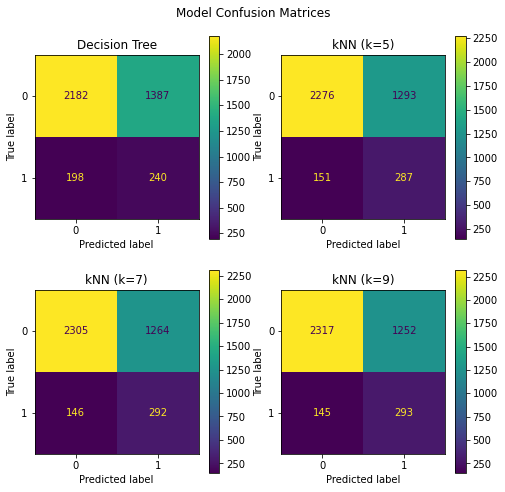

In [60]:
# Train, test, and evaluate different classification models
from sklearn import tree
from sklearn import neighbors
from IPython.display import display

# Classification models to experiment
decision_tree_models = {"Decision Tree":tree.DecisionTreeClassifier()}
knn_models = {"kNN (k=5)":neighbors.KNeighborsClassifier(n_neighbors=5),
            "kNN (k=7)":neighbors.KNeighborsClassifier(n_neighbors=7),
            "kNN (k=9)":neighbors.KNeighborsClassifier(n_neighbors=9)}
models = decision_tree_models | knn_models

# Function to run experiments with multiple classification models
def run_experiments(models, X_train, y_train, X_test, y_test):
    with plt.ioff():
        # Create the performance results dictionary and main plot
        results = {"Model Name":[],"Precision":[],"Recall":[],"F1":[],"Accuracy":[]}
        confusion_matrices, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
        confusion_matrices.suptitle("Model Confusion Matrices")
        confusion_matrices.tight_layout()

        for model_name, ax in zip(list(models.keys()), axs.ravel()):
            # Train/test the model
            model = models[model_name]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Create a confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=ax)
            ax.title.set_text(model_name)

            # Append the performance results
            results['Model Name'].append(model_name)
            results['Precision'].append(precision_score(y_test, y_pred))
            results['Recall'].append(recall_score(y_test, y_pred))
            results['F1'].append(f1_score(y_test, y_pred))
            results['Accuracy'].append(accuracy_score(y_test, y_pred))

        # Show the performance metrics and plot the confusion matrices
        print("Model Results:")
        results_df = pd.DataFrame(results).style.set_caption("Model Performance Metrics")
        display(results_df)
        print()
        plt.show()

run_experiments(models, x_train, y_train, x_test, y_test)